<a href="https://colab.research.google.com/github/Tapanmittal13/Data_Science/blob/master/Assignment_6_A_Remove_Dense_Transition%26bottleneck%20block.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Steps followed to achieve the objective:**

1. Removed dense layer by adding model.addConvolution2D(10,4) and softmax

2. Added transition block/BottleNeck layer ( Maxpooling followed by 1x1 to reduce the number of params ) 

3. Added dropout at transition layer only with values less than 0.2. If i am using it in all layers with value of 2.5,  accuracy is increasing slowly and not coming close to the base accuracy. 

4. Added  Batch Normalisation to increase the accuracy

5. Added image normalisation and L2 regularisation

6. Adding  border_mode='same' helped reach the double the RF of the  image in lesser no. of layers

7. Added checkpoint to show results wrt to best val accuracy

I didn't use LR scheduler as desired accuracy was achieved from my previous learnings.

**The heros of this assigment 6_A were dropout and border_mode.Playing around with these 2 parameters helped me achieve desired result.**

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

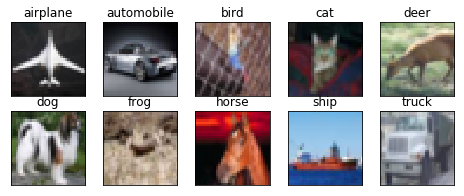

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
from keras import regularizers

# Define the model
model = Sequential()
weight_decay=0.001

#Convolution block
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(weight_decay),input_shape=(32, 32, 3))) #32 #3
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(32, 3, 3,border_mode='same', kernel_regularizer=regularizers.l2(weight_decay))) #32 #5
model.add(Activation('relu'))
model.add(BatchNormalization())


#Transition block
model.add(MaxPooling2D(pool_size=(2, 2))) #16 #10
model.add(Convolution2D(10,1,kernel_regularizer=regularizers.l2(weight_decay))) 
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))


#Convolution block
model.add(Convolution2D(64, 3, 3,border_mode='same', kernel_regularizer=regularizers.l2(weight_decay))) #16 #12
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(64, 3, 3,border_mode='same', kernel_regularizer=regularizers.l2(weight_decay))) #16 #14
model.add(Activation('relu'))
model.add(BatchNormalization())


#Transition block
model.add(MaxPooling2D(pool_size=(2, 2))) #8 #28
model.add(Convolution2D(10,1,kernel_regularizer=regularizers.l2(weight_decay))) 
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))


#Convolution block
model.add(Convolution2D(128, 3, 3,border_mode='same', kernel_regularizer=regularizers.l2(weight_decay))) #8 #30
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(128, 3, 3,border_mode='same', kernel_regularizer=regularizers.l2(weight_decay))) #8 #32
model.add(Activation('relu'))
model.add(BatchNormalization())


#Transition block
model.add(MaxPooling2D(pool_size=(2, 2))) #4 #64
model.add(Convolution2D(10,1,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
#model.add(BatchNormalization())

#Prediction layer
model.add(Convolution2D(10,4))
model.add(Flatten())
model.add(Activation('softmax'))


          
# Compile the model
  
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<ke

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_21 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_22 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [0]:
import numpy as np
from keras.callbacks import Callback
class GetBest(Callback):
    """Get the best model at the end of training.
	# Arguments
        monitor: quantity to monitor.
        verbose: verbosity mode, 0 or 1.
        mode: one of {auto, min, max}.
            The decision
            to overwrite the current stored weights is made
            based on either the maximization or the
            minimization of the monitored quantity. For `val_acc`,
            this should be `max`, for `val_loss` this should
            be `min`, etc. In `auto` mode, the direction is
            automatically inferred from the name of the monitored quantity.
        period: Interval (number of epochs) between checkpoints.
	# Example
		callbacks = [GetBest(monitor='val_acc', verbose=1, mode='max')]
		mode.fit(X, y, validation_data=(X_eval, Y_eval),
                 callbacks=callbacks)
    """

    def __init__(self, monitor='val_loss', verbose=0,
                 mode='auto', period=1):
        super(GetBest, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.period = period
        self.best_epochs = 0
        self.epochs_since_last_save = 0

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('GetBest mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf
                
    def on_train_begin(self, logs=None):
        self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            #filepath = self.filepath.format(epoch=epoch + 1, **logs)
            current = logs.get(self.monitor)
            if current is None:
                warnings.warn('Can pick best model only with %s available, '
                              'skipping.' % (self.monitor), RuntimeWarning)
            else:
                if self.monitor_op(current, self.best):
                    if self.verbose > 0:
                        print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                              ' storing weights.'
                              % (epoch + 1, self.monitor, self.best,
                                 current))
                    self.best = current
                    self.best_epochs = epoch + 1
                    self.best_weights = self.model.get_weights()
                else:
                    if self.verbose > 0:
                        print('\nEpoch %05d: %s did not improve' %
                              (epoch + 1, self.monitor))            
                    
    def on_train_end(self, logs=None):
        if self.verbose > 0:
            print('Using epoch %05d with %s: %0.5f' % (self.best_epochs, self.monitor,
                                                       self.best))
        self.model.set_weights(self.best_weights)

In [0]:
callbacks = [GetBest(monitor='val_acc', verbose=1, mode='max')]


**[Link to Base Accuracy File](https://colab.research.google.com/drive/1abDjPJTWL7nW4AfmjEzKJWUTsGe8JKoQ#scrollTo=xxGvqVSCJhDc)**

Epoch 100/100

390/390 [==============================] - 20s 52ms/step - loss: 0.2632 - acc: 0.9172 - val_loss: 0.6530 - val_acc: 0.8240

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,featurewise_center=True, featurewise_std_normalization=True)
testgen=ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = datagen.flow(test_features, test_labels),validation_steps=len(test_features)//128,callbacks=callbacks,verbose=1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., validation_steps=78, callbacks=[<__main__..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 48s 123ms/step - loss: 1.8591 - acc: 0.4430 - val_loss: 1.5799 - val_acc: 0.5329

Epoch 00001: val_acc improved from -inf to 0.53285, storing weights.
Epoch 2/100
390/390 [==============================] - 46s 118ms/step - loss: 1.4289 - acc: 0.5869 - val_loss: 1.4290 - val_acc: 0.5893

Epoch 00002: val_acc improved from 0.53285 to 0.58934, storing weights.
Epoch 3/100
390/390 [==============================] - 45s 116ms/step - loss: 1.2410 - acc: 0.6455 - val_loss: 1.1717 - val_acc: 0.6603

Epoch 00003: val_acc improved from 0.58934 to 0.66026, storing weights.
Epoch 4/100
390/390 [==============================] - 45s 116ms/step - loss: 1.1185 - acc: 0.6844 - val_loss: 1.1388 - val_acc: 0.6771

Epoch 00004: val_acc improved from 0.66026 to 0.67708, storing weights.
Epoch 5/100
390/390 [==============================] - 45s 116ms/step - loss: 1.0382 - acc: 0.7104 - val_loss: 1.1467 - val_acc: 0.6855

Epoch 00005: val_acc improved from 0.67708

Model took 4573.40 seconds to train


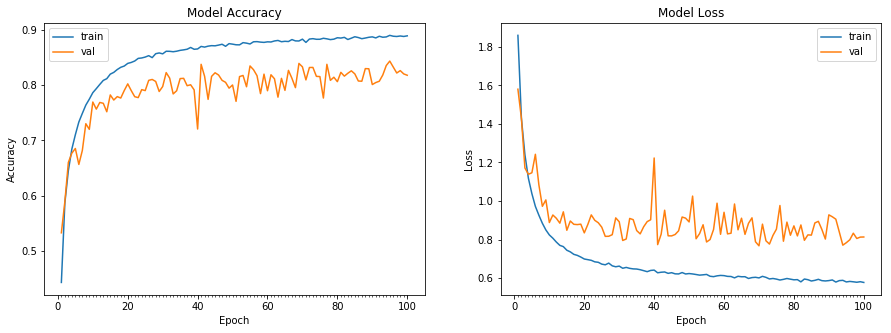

Accuracy on test data is: 84.11


In [0]:
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))